# 卷积神经网络-第一周
卷积神经网络 (Convolutional Neural Networks) 是一种深度学习模型，常用来分析视觉图像。著名计算机科学家 Yann LeCun 是第一个通过卷积神经网络在MNIST数据集上解决手写数字识别问题的人。在第一周的实验中，你将学习使用卷积运算提取图像特征，理解以卷积运算为核心完成计算机视觉任务的深层次动机。

你将学习到：
- 如何手工设计卷积核进行边缘提取
- 理解卷积运算的重要性质和将其用于图像处理的动机
- （可选的）证明卷积运算的平移等变性

<img src="src/lecun.png" style="width:200px;height:200;">


<center>图1. Yann LeCun正在向正在学习计算机视觉的你微笑</center>

## 1. 什么是卷积

首先，我们从加载一张彩色图像开始：

In [3]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

In [4]:
img = Image.open('src\plane2.jpg')
plt.axis("off")
plt.imshow(img)

我们提取出三通道彩色图像的其中一个通道来简化后面的实验：

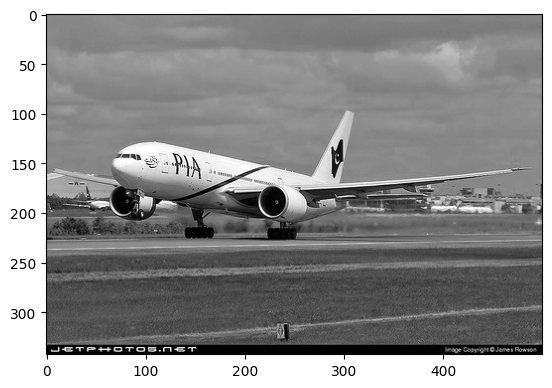

In [5]:
r, g, b = img.split()
data = np.array(r)
n,m = data.shape
plt.figure()
plt.imshow(r, cmap='gray')

卷积运算是卷积神经网络最基础的运算过程。对于一张图像$f(x,y)$和一个卷积核 $w(a,b)$ 而言：卷积$(Convolution)$运算就是对于图像 $f(x,y)$ 中的每个像素，将其作为中心像素，计算它及其邻域像素和$kernel$核 $w(a,b)$ 对应位置元素的乘积，将结果相加到一起，再把得到的值作为该中心像素的新值。重复将$kernel$向下或向左平移一位继续计算每个像素的新值，直到遍历完整个图像，即完成了对图像的卷积操作。

下图展示了卷积操作的动态过程，对于原始图像中的每个元素，将其 $3*3$ 邻域内的元素（位于边界处的元素需要进行扩展）与卷积核按位相乘再取平均，将结果更新在输出矩阵的同一位置上。循环对整张图像上的所有像素执行这一过程。

<img src="src/con_static.jpg" style="width:400px;height:400;">

<img src="src/convolution.gif" style="width:400px;height:400;">

现在，我们尝试定义一个卷积核：

In [6]:
kernel = np.array([
    [1,0,-1],
    [1,0,-1],
    [1,0,-1]
])

并通过循环语句实现上图所示的卷积过程：

In [13]:
def convolution(kernel, data):
    n,m = data.shape
    img_new = []
    for i in range(n-3):
        line = []
        for j in range(m-3):
            a = data[i:i+3,j:j+3]
            line.append(np.sum(np.multiply(kernel, a)))
        img_new.append(line)
    return np.array(img_new)

In [14]:
img_new = convolution(kernel, data)
plt.imshow(img_new, cmap='gray')
plt.axis('off')

(-0.5, 496.5, 339.5, -0.5)

事实上，上面的卷积核实现了图像中**垂直边缘**的提取过程，你可以通过对 kernel 进行修改来观察不同的卷积核提取到的特征的区别。

接下来，我们将继续使用一些简单的例子来理解为什么卷积运算可以用于图像的特征提取。首先，我们加载一张小尺寸且内容比较简单的图像：

In [9]:
np.set_printoptions(edgeitems=14)
img = np.array(Image.open('src/cross.png').convert('L').resize((14,14)), 'f')
plt.imshow(img, cmap='gray')

打印出每个具体的像素值：

In [10]:
print(img)

[[253. 253. 253. 253. 253. 254. 246. 217. 255. 253. 253. 253. 253. 253.]
 [253. 253. 253. 253. 253. 254. 246. 217. 255. 253. 253. 253. 253. 253.]
 [253. 253. 253. 253. 253. 254. 246. 217. 255. 253. 253. 253. 253. 253.]
 [253. 253. 253. 253. 253. 254. 246. 217. 255. 253. 253. 253. 253. 253.]
 [253. 253. 253. 253. 253. 254. 246. 217. 255. 253. 253. 253. 253. 253.]
 [253. 255. 255. 255. 255. 255. 248. 219. 255. 255. 255. 255. 255. 253.]
 [253. 226. 212. 214. 214. 214. 208. 184. 215. 214. 214. 213. 223. 253.]
 [253. 248. 246. 246. 246. 247. 240. 211. 248. 246. 246. 246. 248. 253.]
 [253. 253. 254. 254. 254. 255. 247. 218. 255. 254. 254. 254. 253. 253.]
 [253. 253. 253. 253. 253. 254. 246. 217. 255. 253. 253. 253. 253. 253.]
 [253. 253. 253. 253. 253. 254. 246. 217. 255. 253. 253. 253. 253. 253.]
 [253. 253. 253. 253. 253. 254. 246. 217. 255. 253. 253. 253. 253. 253.]
 [253. 253. 253. 253. 253. 254. 246. 216. 255. 253. 253. 253. 253. 253.]
 [253. 253. 253. 253. 253. 254. 247. 225. 254. 253.

如果我们将空间坐标 $(x,y)$ 的像素值看作二元函数：$z=f(x,y)$，不难发现图像的边缘都是 $z$ 对 $x$ 或 $y$ 的偏导数 $\frac{ \partial z }{ \partial x }$ 或 $\frac{ \partial z }{ \partial y }$ 较大的位置。具体地，$\frac{ \partial z }{ \partial x }$ 较大的位置是纵向的边缘（十字形状竖线与白色背景的交界处），$\frac{ \partial z }{ \partial y }$ 较大的位置是横向边缘（十字形状横线与白色背景的交界处）。

因此，当卷积核kernel遇到图像中的垂直边界时，执行卷积运算得到的响应值$H_x$会比较高：

\begin{equation}
H_x={
\left[ \begin{array}{ccc}
1 & 0 & -1\\
1 & 0 & -1\\
1 & 0 & -1
\end{array} 
\right ]}\cdot
{
\left[ \begin{array}{ccc}
254 & 246 & 217\\
254 & 246 & 217\\
254 & 246 & 217
\end{array} 
\right ]}
\end{equation}

In [12]:
feature_map = convolution(kernel, img)
plt.imshow(feature_map, cmap='gray')
plt.axis('off')

(-0.5, 10.5, 10.5, -0.5)

### 实验问题1：手动设计卷积核
**练习**：现在，你需要手动设计新的卷积核，实现对图像中45度倾斜边缘的提取

**要求**：
- 输入img：包含45度倾斜边缘的灰度图像
- 输出feature map：卷积后得到的特征图像，45度倾斜边缘处的响应值明显高于其他位置

(-0.5, 26.5, 26.5, -0.5)

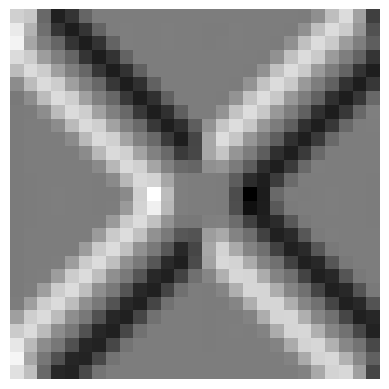

In [12]:
## 这里填充的是错误的答案，你需要删掉它替换成正确的
## YOUR CODE BEGIN
kernel_45 = np.array([
    [1,0,-1],
    [1,0,-1],
    [1,0,-1]
])
## YOUR CODE END


x = np.array(Image.open('src/xmark.png').convert('L').resize((30,30)), 'f')
feature_map = convolution(kernel_45, x)
plt.imshow(feature_map, cmap='gray')
plt.axis('off')

卷积之后你的特征图上应该只有从左下角延伸到右上角一条线段（中心处可能存在截断），如果出现了其他高响应值的区域，你可能需要再仔细检查一下代码。

## 2. 卷积运算的性质

在学习卷积运算时，我们首先需要理解其形式化定义，以及它在计算机视觉任务中的动机和应用。卷积是一个重要的数学概念，广泛应用于信号处理、图像处理等领域。接下来，我们将从基本定义入手，逐步探讨卷积及其在计算机视觉中的变体。

### 2.1 卷积的定义

卷积是对两个实变函数的一种数学运算，通常用于描述系统对输入信号的响应或对信号进行平滑处理。假设一个传感器在每个时刻 $ t $ 输出信号 $ x(t) $，为了减少噪声的影响，我们可以通过对临近时刻的信号进行**加权平均**来得到更稳定的输出。加权函数 $ w(a) $（其中 $ a $ 是时间间隔）定义了每个时刻的权重，最终的输出信号 $ s(t) $ 可以表示为：

$$
s(t) = \int_{-\infty}^{\infty} x(a) w(t - a) \, da
$$

这种运算称为**卷积**，通常用星号表示：

$$
s(t) = (x * w)(t)
$$

在信号处理中，$ w $ 通常是一个概率密度函数（其积分等于 1），以确保输出是加权平均的结果。这里，$ x $ 是输入信号，$ w $ 是核函数（kernel function），而 $ s $ 是输出的特征映射（feature map）。

#### 离散卷积
在实际应用中，数据往往是离散的。例如，如果传感器仅在离散时刻 $ t \in \mathbb{N} $ 输出信号，卷积的定义变为离散形式：

$$
s(t) = \sum_{a=-\infty}^{\infty} x(a) w(t - a)
$$

这表示在每个时刻 $ t $，输出 $ s(t) $ 是输入信号 $ x $ 与核函数 $ w $ 的加权和。

#### 二维卷积
在图像处理中，图像是二维数据。以灰度图像 $ I $ 为例，其像素值分布在二维坐标 $ (m, n) $ 上，使用二维核函数 $ K $ 进行的卷积运算定义为：

$$
S(i, j) = (I * K)(i, j) = \sum_{m} \sum_{n} I(m, n) K(i - m, j - n)
$$

这里，$ I(m, n) $ 是图像在位置 $ (m, n) $ 的像素值，$ K $ 是卷积核，$ S(i, j) $ 是输出的特征映射，表示图像在位置 $ (i, j) $ 处经过卷积核处理后的结果。

### 计算机视觉中的卷积

尽管上述定义是数学上的严格卷积，但在计算机视觉和深度学习中，实际使用的运算稍有不同。通常，我们使用的是**互相关（cross-correlation）**，而不是严格意义上的卷积。互相关的定义为：

$$
S(i, j) = \sum_{m} \sum_{n} I(m, n) K(i + m, j + n)
$$

与卷积的主要区别在于，互相关不涉及核函数 $ K $ 的翻转（即不将 $ K(i - m, j - n) $ 改为 $ K(i + m, j + n) $）。在数学上，卷积需要将核函数沿水平和垂直方向翻转后再进行计算，而互相关直接使用核函数的原始形式。

然而，在计算机视觉领域（尤其是在卷积神经网络中），这种互相关运算通常仍被称为“卷积”。这种称呼上的混淆并不影响实际应用，因为深度学习模型会通过训练自动调整核函数的参数，使其适应具体任务。因此，在实践中，是否翻转核函数对结果的影响可以忽略。

#### 卷积核的作用
在计算机视觉中，卷积核是一个小的矩阵（例如 $ 3 \times 3 $ 或 $ 5 \times 5 $），通过在图像上滑动，计算每个位置的加权和。这种操作可以提取图像中的特定特征，例如边缘、纹理或角点。例如，一个边缘检测核可能如下所示：

$$
\begin{bmatrix}
-1 & 0 & 1 \\
-1 & 0 & 1 \\
-1 & 0 & 1 \\
\end{bmatrix}
$$

当这个核滑动过图像时，它会突出显示垂直边缘。

#### 特征映射
卷积运算的输出 $ S $ 称为特征映射，它反映了图像与卷积核的相似性。每个元素 $ S(i, j) $ 表示图像在位置 $ (i, j) $ 附近区域的特征强度。多个不同的卷积核可以生成多个特征映射，从而捕获图像中的多种特征。

### 总结
卷积是一个核心数学工具，用于信号处理和图像处理中。其基本定义涉及输入信号与核函数的加权运算，支持连续、离散和二维形式。在计算机视觉中，尽管实际使用的是互相关，但习惯上仍称之为卷积。这种运算通过卷积核提取图像特征，是深度学习和图像处理任务的基础。理解卷积的定义及其在计算机视觉中的变体，有助于深入掌握相关技术。

### 实验问题2：手动实现卷积函数
**练习**：现在，你需要手动设计卷积函数,要求能够处理不同size的卷积核

**要求**：
- 输入data：要进行卷积操作的灰度图像
- 输入kenel：卷积核
- 输出feature map：卷积后得到的特征图像

In [ ]:
# def convolution(kernel, data):
#     n,m = data.shape
#     img_new = []
#     for i in range(n-3):
#         line = []
#         for j in range(m-3):
#             a = data[i:i+3,j:j+3]
#             line.append(np.sum(np.multiply(kernel, a)))
#         img_new.append(line)
#     return np.array(img_new)

# 上述函数只能处理3*3的卷积核，请你手动实现一个可以处理不同size的卷积核

def my_convolution(kernel, data):
    # 写入你的代码
    return

#设计简单的验证程序（设计3*3、5*5的卷积核对同一图片进行测试）
#写入你的验证代码

plt.imshow(feature_map, cmap='gray')
plt.axis('off')

给出卷积的形式化定义后，我们接着对卷积的一些重要性质进行研究：
- 等变表示（equivariant representation）
- 稀疏交互（sparse interactions）

### 2.2 稀疏交互

当处理一张图像时，卷积核的大小往往显著的小于图像的大小，只需要存储极小规模的参数就可以检测到图像中有用的信息（例如图像的边缘），这意味着使用卷积操作来进行图像特征的提取是高效率的。

### 实验问题3：验证卷积操作的稀疏交互性质
**练习**：以边缘检测为例，验证卷积操作的稀疏交互性质。

**要求**：
分别计算两种边缘检测算法需要的浮点运算次数。
- 算法1：用矩阵乘法进行计算
- 算法2：用第1部分中你实现的卷积核进行计算

输入图像为800\*600大小的灰度图像

矩阵乘法进行边缘提取的输出结果仍为800\*600，因此需要使用一个矩阵W来记录输入和输出之间任意两个像素的关系，W的规模为800\*600\*800\*600，需要的浮点运算次数为：800\*600\*800\*600=2.304\*10^11次。

卷积运算浮点运算次数：_____(填空)

### 2.3 等变表示

如果一个函数满足：输入改变，输出也会以同样的方式改变，我们就称这一函数具有等变性。具体地，如果函数$f(x)$与$g(x)$满足$f(g(x))=g(f(x))$，那么称$f(x)$对变换$g$具有等变性。

接下来，我们用实验验证卷积运算对于平移操作具有等变性，即：
原始图像平移后卷积和卷积后平移的结果是一样的

In [29]:
import cv2
M = np.float32([[1, 0, 0], [0, 1, 5]])
x_temp = cv2.warpAffine(x, M, (x.shape[1], x.shape[0]))
feature_map = convolution(kernel_45, x_temp)
plt.imshow(feature_map, cmap='gray')
plt.axis('off')

(-0.5, 26.5, 26.5, -0.5)

### 实验问题4：验证卷积操作的平移等变性
**练习**：填充代码，以边缘检测为例，验证卷积操作的平移等变性质。

(-0.5, 26.5, 26.5, -0.5)

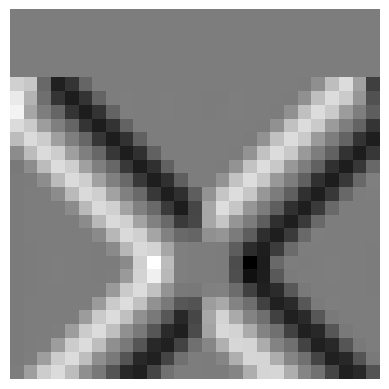

In [28]:
import cv2
###YOUR CODE BEGIN


###YOUR CODE END
plt.imshow(feature_map, cmap='gray')
plt.axis('off')

不考虑边缘的影响，两次运行结果应该是一致的。

**可选任务**：证明一维连续卷积运算的平移等变性

**要求**：在报告中展示你的证明过程

**命题**：
考虑如下形式的卷积：

$$
s(t)=x(\tau)*w(\tau)(t):=\int_{-\infty}^{+\infty}x(\tau)\cdot w(\tau)(t)d \tau
$$

其中，$x(t),w(t)\in \mathbb{R}$，且在定义域上可积。则：

$s(t)$对平移变换$g(t)=t-\Delta t$具有等变性，即：

$$
s(g(t))=g(s(t))
$$

最后，需要明确清楚的是：

（1）尽管卷积对亮度变化、平移等操作具有天然的等变性，对于缩放、旋转等变化并不具备等变性，因此需要额外的机制来搭建强大的计算机视觉模型（例如池化层、额外的正则技术、数据增强手段等）；

（2）等变表示、稀疏交互仅仅是卷积神经网络取得成功的部分原因，除此之外还包括：参数共享和一些仿生学角度的优势；

（3）事实上，近年来其他完全不依赖于卷积的模型也在计算机视觉任务中取得了优秀的表现，这表明卷积对于视觉任务而言并不是必不可少的，计算机视觉模型仍有很大的探索空间；